(lecture14:covariance)=
# Covariance between two random variables

The concept of covariance summarizes with a single number how two random variables $X$ and $Y$ vary together.
And there are three possibilities:

- if $X$ is increased, then $Y$ will likely increase,
- if $Y$ is decreased, then $Y$ will likely decrease, and
- $X$ and $Y$ are not linked.

Before defining these concepts exactly, let's load the smart buildings dataset which will help us demonstrate the concept.
Here we go:

In [17]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

import numpy as np
import scipy.stats as st

In [18]:
# The url of the file we want to download
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/temperature_raw.xlsx'
!curl -O $url

import pandas as pd
df = pd.read_excel('temperature_raw.xlsx')
df = df.dropna(axis=0)
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277k  100  277k    0     0   557k      0 --:--:-- --:--:-- --:--:--  557k


household        date  score     t_out     t_unit        hvac
0        a1  2018-01-07  100.0  4.283373  66.693229  246.473231
1       a10  2018-01-07  100.0  4.283373  66.356134    5.492116
2       a11  2018-01-07   58.0  4.283373  71.549132  402.094327
3       a12  2018-01-07   64.0  4.283373  73.429514  211.692244
4       a13  2018-01-07  100.0  4.283373  63.923937    0.850536

Here is the scatter plot of `hvac` (consumed HVAC energy in kWh) and `t_out` (external temperature in degrees F):

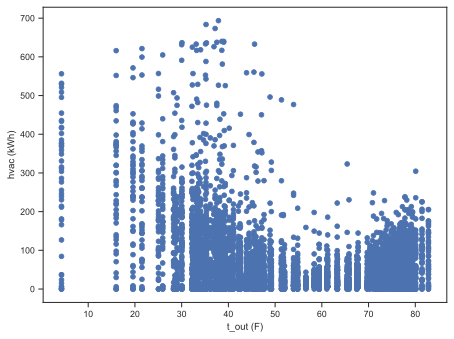

In [19]:
fig, ax = make_full_width_fig()
ax.scatter(df['t_out'], df['hvac'])
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
save_for_book(fig, 'ch14.fig1')

We see three clear regions here, heating, cooling, and off.
Let me separate the data in different dataframes corresponding to these three regions.

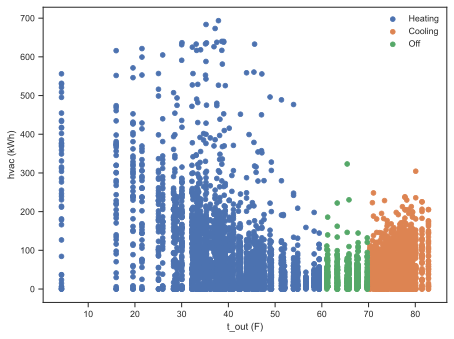

In [20]:
df_heating = df[df['t_out'] < 60]
df_cooling = df[df['t_out'] > 70]
df_off = df[(df['t_out'] >= 60) & (df['t_out'] <= 70)]
fig, ax = make_full_width_fig()
ax.scatter(df_heating['t_out'], df_heating['hvac'], label='Heating')
ax.scatter(df_cooling['t_out'], df_cooling['hvac'], label='Cooling')
ax.scatter(df_off['t_out'], df_off['hvac'], label='Off')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best')
save_for_book(fig, 'ch14.fig2')

The covariance and the correlation will allow us to characterize the relationship between $X=$`t_out` and $Y=$`hvac` in each one of these regions with a single number.
Depending on the sign of this number (positive, negative, or zero), we can say how the relationship between $X$ and $Y$ goes.
In these three regions we find:

+ Heating region (`t_out` < 60 F): In this regime, increasing $X=$`t_out` decreases energy consumption $Y=$`hvac` because you use less heating. In the mathematical jargon, we say that $X$ and $Y$ are *negatively correlated*.
+ Cooling region (`t_out` > 70 F): In this regime, increase $X=$`t_out` increases energy consumption $Y=$`hvac` because you use more cooling. In the mathematical jargon, we say that $X$ adn $Y$ are *positively correlated*.
+ Off region (60 F <= `t_out` <= 70 F): In this regime, the $X=$`t_out` does not affect energy consumption because the HVAC is most likely off. In the mathematical jargon, we say that $X$ and $Y$ are *uncorrelated*.

Okay, this is good.
We are going to do two things next.
I will first give you the mathematical definition of covariance and correlation and second I will show you how to estimate them from the data we have.
Let's go.

## Mathematical definition of covariance

Let $p(x,y)$ be the joint PDF of the random variables $X$ and $Y$.
We may or we may not know this, but it certainly exists.
Now, let

$$
\mu_X = \mathbf{E}[X],
$$

be the mean of $X$ and

$$
\mu_Y = \mathbf{E}[Y],
$$

be the mean of $Y$.
The covariance of $X$ and $Y$ is defined to be:

$$
\mathbf{C}[X, Y] := \mathbf{E}\left[(X-\mu_X)(Y-\mu_Y)\right].
$$

So, it is the expectation of the product $(X-\mu_X)(Y-\mu_Y)$.
Why is this a good definition of how $X$ and $Y$ vary together?
To develop your intuition about it, let's look at what the covariance turns out to be in three specific cases:

### Case 1: If $X$ and $Y$ are independent, then the covariance is zero 
Let's assume that $X$ and $Y$ are independent.
Then, their joint PDF would factorize:

$$
p(x,y) = p(x)p(y).
$$

This can be exploited to show that $\mathbf{C}[X,Y]$ would be exactly zero.
Here it is:

$$
\begin{split}
\mathbf{C}[X,Y] &= \mathbf{E}\left[(X-\mu_X)(Y-\mu_Y)\right]\\
&= \int (x-\mu_X)(y-\mu_Y)p(x,y)dxdy\\
&= \int (x-\mu_X)(y-\mu_Y)p(x)p(y)dxdy\;\text{(independence)}\\
&= \int (x-\mu_X)p(x)dx\int(y-\mu_Y)p(y)dy\;\text{(calculus)}\\
&= \mathbf{E}[X-\mu_X]\cdot\mathbf{E}[Y-\mu_Y]\;\text{(definition of expectation)}\\
&= 0\cdot 0\\
&= 0
\end{split}
$$

### Case 2: If $Y=aX+b$ for some positive constant $a$, then the covariance is positive

Let's assume that there is a very simple relationship between $X$ and $Y$:

$$
Y = a X+b,
$$

for some $a$ positive, and an arbitrary $b$.
This is the simplest way in which an increase in $X$ would yield and increase in $Y$.
Let's see what covariance we get in this case.
Notice that the mean of $Y$ is now:

$$
\mu_Y = \mathbf{E}[Y] = \mathbf{E}[aX+b] = a\mathbf{E}[X]+b = a\mu_X+b.
$$

So, the covariance is:

$$
\begin{split}
\mathbf{C}[X,Y] &= \mathbf{E}\left[(X-\mu_X)(Y-\mu_Y)\right]\\
&= \mathbf{E}\left[(X-\mu_X)(aX+b-a\mu_X-b)\right]\\
&= \mathbf{E}\left[(X-\mu_X)a(X-\mu_X)\right]\\
&= \mathbf{E}\left[a(X-\mu_X)^2\right]\\
&= a\mathbf{E}\left[(X-\mu_X)^2\right]\\
&= a\mathbf{V}\left[X\right],
\end{split}
$$

which is, of course, positive because both $a$ and the variance of $X$ are positive.

### Case 3: If $Y=-aX+b$ for some positive constant $a$, then the covariance is negative

Let's assume that there is a very simple relationship between $X$ and $Y$:

$$
Y = -a X+b,
$$

for some $a$ positive, and an arbitrary $b$.
This is the simplest way in which an increase in $X$ would yield and decrease in $Y$.
In exactly the same way as before, we can show that:

$$
\mathbf{C}[X,Y] = -a\mathbf{V}[X],
$$

which is a negative number.

## Empirical estimation of the covariance

Alright, so the covariance does have the intuitive meaning that we want.
But, how can we find it if we do not know the joint PDF $p(x,y)$.
We will show how you can estimate it from samples of $X$ and $Y$?
So, let's say that we have $N$ measurements of $X$ and $Y$, say $(x_i, y_i)$ for $i=1,\dots,N$.
We need the means, which we already know how to estimate:

$$
\hat{\mu}_X = \frac{1}{N}\sum_{i=1}^Nx_i,
$$

and

$$
\hat{\mu}_Y = \frac{1}{N}\sum_{i=1}^Ny_i,
$$

Okay, we need to estimate one more expectation.
Let's do it:

$$
\begin{split}
\mathbf{C}[X,Y] &= \mathbf{E}\left[(X-\mu_X)(Y-\mu_Y)\right]\\
&\approx \mathbf{E}\left[(X-\hat{\mu}_X)(Y-\hat{\mu}_Y)\right]\;\text{(replacing means with estimates)}\\
&\approx \frac{1}{N}\sum_{i=1}^N(x_i-\hat{\mu}_X)(y_i-\hat{\mu}_Y)\;\text{(sampling estimate of expectation)}.
\end{split}
$$

So, here is our estimate of the covariance:

$$
\hat{\sigma}_{X,Y} = \frac{1}{N}\sum_{i=1}^N(x_i-\hat{\mu}_X)(y_i-\hat{\mu}_Y).
$$

```{note}
The standard estimate of covariance differs a bit from what I have above.
It is usually estimated by:

$$
\tilde{\sigma}_{X,Y} = \frac{1}{N-1}\sum_{i=1}^N(x_i-\hat{\mu}_X)(y_i-\hat{\mu}_Y).
$$

This is a so-called *unbiased estimator*.
However, if $N$ is big enough the difference is negligible and we don't have to worry about it.
```

## Example: Covariance between `t_out` and `hvac` during heating, cooling, and off

Let's now calculate the estimate we developed for the covariance in the smart buildings dataset.
In particular, we are going to estimate the covariance between $X=$`t_out` and $Y=$`hvac` for the three regions considered.

Fortunately, we do not have to calculate it by hand.
We can use built-in functionality of [`np.cov`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html).
Here is how.
Let's do first cooling.

In [21]:
C = np.cov(df_cooling['t_out'], df_cooling['hvac'])
print(C)

[[   9.74568849   36.85230047]
 [  36.85230047 2299.42112855]]


Let me explain to you what `np.cov()` returns in our case.
First, you notice we have returns a 2 x 2 matrix $C$.
The diagonal of that matrix include the variances of the two datasets.
So, here `C[0,0]` is the variance of `df_cooling['t_out']`.
Check this out:

In [22]:
print(f"Variance of df_cooling['t_out'] = {df_cooling['t_out'].var():1.2f}")
print(f"Compare to C[0, 0] = {C[0, 0]:1.2f}")

Variance of df_cooling['t_out'] = 9.75
Compare to C[0, 0] = 9.75


Similarly, `C[1,1]` is the variance of `df_cooling['hvac']`:

In [23]:
print(f"Variance of df_cooling['hvac'] = {df_cooling['hvac'].var():1.2f}")
print(f"Compare to C[1, 1] = {C[1, 1]:1.2f}")

Variance of df_cooling['hvac'] = 2299.42
Compare to C[1, 1] = 2299.42


Okay.
Now `C[0, 1]` is the covariance between the first input (0 = `t_out`) and the second input (1 = `hvac`).
Here it is:

In [24]:
print(f"C['t_out', 'hvac'|cooling] = {C[0, 1]:1.2f}")

C['t_out', 'hvac'|cooling] = 36.85


This is positive for cooling as we expected.
Increasing `t_out` results in increasing `hvac`.

But what is `C[1, 0]`. Well, this is the covariance between the second input (1 = `hvac`) and the first input (0 = `t_out`):

In [25]:
print(f"C['hvac', 't_out'|cooling] = {C[1, 0]:1.2f}")

C['hvac', 't_out'|cooling] = 36.85


This is exactly the same as `C[0, 1]`. Of course, this is not an accident.
The covariance between two random variables is a symmetric operator, i.e.,

$$
\mathbf{C}[X, Y] = \mathbf{C}[Y,X].
$$

The proof is trivial. Just look at the definition of covariance.

Alright, let's now look at the heating covariance:

In [26]:
C = np.cov(df_heating['t_out'], df_heating['hvac'])
print(C)

[[  105.27235776  -525.43752907]
 [ -525.43752907 12967.67912181]]


In [27]:
print(f"C['hvac', 't_out'|heating] = {C[1, 0]:1.2f}")

C['hvac', 't_out'|heating] = -525.44


It is a nice negative number.
Again, this is compatible with our intuition.
Negative means that if `t_out` is increased, `hvac` decreases.
That's exactly what should be happening during heating.

Let's do the off regime:

In [28]:
C = np.cov(df_off['t_out'], df_off['hvac'])
print(C)

[[   8.08975479   -2.65681839]
 [  -2.65681839 1306.35076875]]


In [29]:
print(f"C['hvac', 't_out'|off] = {C[1, 0]:1.2f}")

C['hvac', 't_out'|off] = -2.66


This is smaller in absolute value than any of the other covariance.
But it is still negative...
Is this -2.66 negligible? Or is it big?
How do we know?

Well, that is what the correlation coefficient is going to help us decide...